<a href="https://colab.research.google.com/github/Ramprabu95/AI_based_image_compression/blob/main/Learning_convolutional_Networks_for_Content_weighted_Image_Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Convolutional Networks for Content Weighted Image Compression

# **Introduction:**


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

In [26]:
device = torch.device('cuda')
# Definition of convolution layer
def conv(ni, nf, kernal_size=3, stride=1, padding=1, **kwargs):
    _conv = nn.Conv2d(ni, nf, kernel_size=kernal_size,stride=stride,padding=padding, **kwargs)
    nn.init.kaiming_normal_(_conv.weight)
    nn.init.zeros_(_conv.bias)
    return _conv

# Definition of a residual block
class ResBlock(nn.Module):
  def __init__(self, ni, nh=128):
    super(ResBlock,self).__init__()
    self.conv1 = conv(ni, nh)
    self.conv2 = conv(nh, ni)
  def forward(self, x):
    return x  + self.conv2(F.relu(self.conv1(x)))

# Definition of Relu block
relu = nn.ReLU()

# Definition of encoder
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.step1 = nn.Sequential(conv(3, 128, 8, 4, 2), relu,
                                   ResBlock(128), relu,
                                   conv(128, 256, 4, 2, 1), relu,
                                   ResBlock(256), relu,
                                   ResBlock(256), relu)
  def forward(self,x):
    x = self.step1(x)
    return(x)

# Function that does the binarizing action
class Binarizing_function(torch.autograd.Function):
  @staticmethod
  def forward(ctx, i):
    return (i>0.5).float()
  
  @staticmethod
  def backward(ctx,grad_output):
    return grad_output

def binary_value(x):
  return Binarizing_function.apply(x)

class Bin(nn.Module):
  def __init__(self,func):
    super(Bin,self).__init__()
    self.func = func

  def forward(self,x):
    return self.func(x)

# Definition of binarize 
class Encoder_full(nn.Module):
  def __init__(self,return_imp_map = False):
    super(Encoder_full,self).__init__()

    # Layer that contains the binarizer
    self.step2 = nn.Sequential(Encoder(),
                               conv(256,64,3,1,1),
                               nn.Sigmoid(),
                               Bin(binary_value))
    
    # Layer that contains the importance map 
    self.importance_map = nn.Sequential(Encoder(),
                                        conv(256,128),
                                        relu,
                                        conv(128,128),
                                        relu,
                                        conv(128,1),
                                        nn.Sigmoid())
    
  def forward(self,x):
    if return_imp_map == True:
      return self.importance_map(x)
    else:
      return self.step2(x)

# Quantizer of the importance map
class Quantizing(torch.autograd.Function):
  @staticmethod
  def forward(ctx, i):
    p = i.clone()
    L = 16
    for l in range(L):
      p[(p>=1/L)*(p<(l+1)/L)] = l
    return p
  @staticmethod
  def backward(ctx, grad_output):
    return grad_output
  
def quantize_values(x):
  return Quantizing.apply(x)

class Masking(torch.autograd.Function):
  @staticmethod
  def forward(ctx,i):
    N,_,H,W = i.shape
    n = 64 # as per the paper
    L = 16 # as per the paper
    mask = torch.zeros(n,N*H*W).to(device)
    q_important = i
    q_important_flat = q_important.view(1, N*H*W)
    for index in range(n):
      mask[index,:] = torch.where(index< n/L)*q_important_flat,torch.Tensor([1]).to(device),torch.Tensor([0]).to(device)
    mask = mask.view(n,N,H,W).permute((0,1,2,3))
    return mask
  @staticmethod
  def backward(ctx, grad_output):
     N,_,H,W = grad_output.shape
     if grad_output.is_cuda: return torch.ones(N,1,H,W).cuda()
     else: return torch.ones(N,1,H,W)

# function to generate mask
def generateMask(x):
  return Masking.apply(x)
  

# A decoder is to be defined which is a reverse of the encoder generated

class BitstoImage(torch.nn.Module):
  
  def __init__(self,blocksize):
    super(BitstoImage, self).__init__()
    self.blocksize = blocksize
  
  def forward(self,x):
    N,C,H,W = x.size()
    x = x.view(N, self.blocksize, self.blocksize,C // (self.blocksize ** 2), H, W)
    x = x.permute(0,3,4,1,5,2).contiguous()
    x = x.view(N, C // (self.blocksize ** 2), H*self.blocksize, W*self.blocksize)
    return x

# Decoder design for rebulding the encoded data
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    # the convolution layers of a decoder is the reverse of the encoder
    self.decoder = nn.Sequential(conv(64,512,1,1,0), relu,
                                    ResBlock(512), relu,
                                    ResBlock(512), relu,
                                    ResBlock(512), relu,
                                    BitstoImage(2),
                                    conv(128,512), relu,
                                    ResBlock(512), relu,
                                    ResBlock(512), relu,
                                    BitstoImage(2),
                                    conv(128,512), relu,
                                    ResBlock(512), relu,
                                    ResBlock(512), relu,
                                    ResBlock(512), relu,
                                    BitstoImage(2),
                                    conv(128,1028),relu,
                                    ResBlock(1028), relu,
                                    ResBlock(1028), relu,
                                    ResBlock(1028), relu,
                                    conv(1028,128), relu,
                                    ResBlock(128), relu,
                                    ResBlock(128), relu,
                                    ResBlock(128), relu,                                
                                    conv(128,64), relu,
                                    ResBlock(64), relu,
                                    ResBlock(64), relu,
                                    ResBlock(64), relu,                                 
                                    conv(64,32),relu,
                                    ResBlock(32), relu,
                                    ResBlock(32), relu,
                                    ResBlock(32), relu,
                                    conv(32,3))

  def forward(self,x):
    return self.decoder(x)


encoder_full = Encoder_full(False)
print('********************Encoder Parameters***********************')
print(encoder_full.parameters)
importance_map_full = Encoder_full(True)
print('********************Importance Map Parameters***********************')
print(importance_map_full.parameters)
decoder_full = Decoder()
print('********************Decoder Parameters***********************')
print(decoder_full.parameters)

********************Encoder Parameters***********************
<bound method Module.parameters of Encoder_full(
  (step2): Sequential(
    (0): Encoder(
      (step1): Sequential(
        (0): Conv2d(3, 128, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
        (1): ReLU()
        (2): ResBlock(
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (3): ReLU()
        (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): ReLU()
        (6): ResBlock(
          (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (7): ReLU()
        (8): ResBlock(
          (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(128, 256, kernel_size=(3, 3), s

In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


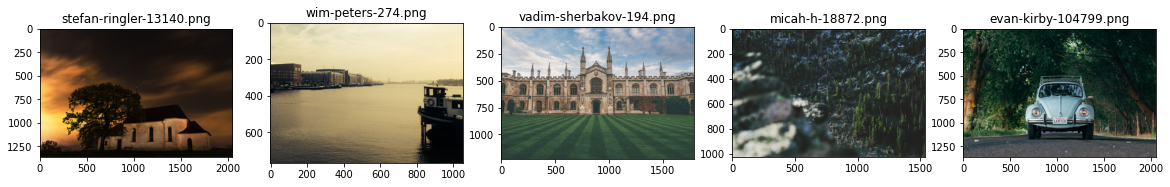

In [4]:
import os 
import random                                                                     
dir_root = '/content/drive/MyDrive/Colab Notebooks/'    
train_dir = os.path.join(dir_root, 'train (1)') 
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(train_dir))
    image_path= os.path.join(train_dir, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [5]:
from PIL import Image
TRAIN_TRANSFORMS_256 = transforms.Compose([transforms.RandomCrop(size = 256),
                                                   transforms.ToTensor()])
def load_image(path):
    return Image.open(path)
def create_dataset(img_folder):
    count = 0
    img_data_array=[]
    for file in os.listdir(img_folder):
        count = count+ 1
        image_path= os.path.join(img_folder,  file)
        image= load_image(image_path)
        image_tensor = TRAIN_TRANSFORMS_256(image)
        img_data_array.append(image_tensor)
    return img_data_array
# extract the image array and class name
train_img_data =create_dataset(train_dir)
train_loader = torch.utils.data.DataLoader(train_img_data, batch_size=1, shuffle=True)

In [27]:
import argparse
import torch
import torch.nn
from torch.utils.data import DataLoader
import os
from torchvision.utils import save_image
class full_layers(nn.Module):
  def __init__(self):
        super(full_layers, self).__init__()
        self.encoder = Encoder_full()
        self.decoder = Decoder()     
  def forward(self,x):
        return self.decoder(self.encoder(x))
fullnet = full_layers().to(device)
return_imp_map = False
optimizer = torch.optim.Adam(fullnet.parameters(), lr=0.0001, weight_decay=1e-7)
loss_fn = nn.MSELoss()
running_loss = 0.0
trial = [[[]]]
for epoch in range(3):
  for i,data in enumerate(train_img_data, 0):
    inputs = data.unsqueeze(0).to(device)
    trial = inputs
    inputs = Variable(inputs)
    optimizer.zero_grad()
    output = fullnet(inputs)
    loss = torch.sqrt(loss_fn(output, inputs))
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i%10 == 9:
      print('[%5d sets] loss: %.3f'% (i+1,running_loss/10))
      running_loss = 0.0
print('Training completed')

print('Learnig Concolutional Networks for content-weighted image compression')
print('Step1 : Loading of the training data')

print('Step2 : Training of the encode created')
print('Step3 : Training of the importance map generator')
print('Step4 : Testing the compression')
PATH = './cifar_net.pth'
torch.save(fullnet.state_dict(), PATH)


[   10 sets] loss: 566.829
[   20 sets] loss: 3.035
[   30 sets] loss: 1.235
[   40 sets] loss: 0.698
[   50 sets] loss: 0.494
[   60 sets] loss: 0.456
[   70 sets] loss: 0.392
[   80 sets] loss: 0.357
[   90 sets] loss: 0.353
[  100 sets] loss: 0.334
[  110 sets] loss: 0.326
[  120 sets] loss: 0.357
[  130 sets] loss: 0.341
[  140 sets] loss: 0.376
[  150 sets] loss: 0.338
[  160 sets] loss: 0.283
[  170 sets] loss: 0.289
[  180 sets] loss: 0.272
[  190 sets] loss: 0.368
[  200 sets] loss: 0.277
[  210 sets] loss: 0.306
[  220 sets] loss: 0.322
[  230 sets] loss: 0.329
[  240 sets] loss: 0.331
[  250 sets] loss: 0.278
[  260 sets] loss: 0.278
[  270 sets] loss: 0.300
[  280 sets] loss: 0.295
[  290 sets] loss: 0.301
[  300 sets] loss: 0.225
[  310 sets] loss: 0.339
[  320 sets] loss: 0.316
[  330 sets] loss: 0.340
[  340 sets] loss: 0.300
[  350 sets] loss: 0.222
[  360 sets] loss: 0.305
[  370 sets] loss: 0.296
[  380 sets] loss: 0.254
[  390 sets] loss: 0.242
[  400 sets] loss: 0.33

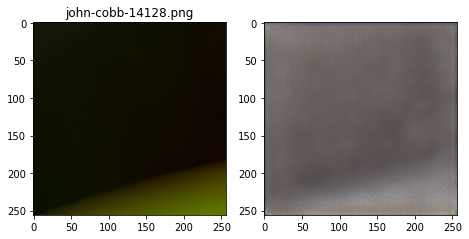

In [35]:
import os 
import random     
from PIL import Image
fullnet = full_layers()
fullnet.load_state_dict(torch.load(PATH))
dir_root = '/content/drive/MyDrive/Colab Notebooks/'    
train_dir = os.path.join(dir_root, 'train (1)') 
TRAIN_TRANSFORMS_reverse = transforms.Compose([transforms.ToPILImage()])
plt.figure(figsize=(20,20))
for i in range(1):
  file = random.choice(os.listdir(train_dir))
  image_path= os.path.join(train_dir, file)
  image= load_image(image_path)
  image_tensor = TRAIN_TRANSFORMS_256(image)
  inputs = image_tensor.unsqueeze(0)
  inputs = Variable(inputs)
  output = fullnet(inputs)
  ax=plt.subplot(1,5,i+1)
  ax.title.set_text(file)
  plt.imshow(TRAIN_TRANSFORMS_reverse(image_tensor.squeeze_(0)))
  ax=plt.subplot(1,5,i+2)
  plt.imshow(TRAIN_TRANSFORMS_reverse(output.squeeze_(0)))